Библиотеки

In [1]:
from ultralytics import YOLO
import cv2
import numpy as np
import matplotlib.pyplot as plt

Ф-я для нормального отображения цветов

In [2]:
def plot_img(image):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.show()

Загрузка весов

In [3]:
weights_version = "13-04-2024"

weights = "detector"
# weights = "segmentator"

In [4]:
model = YOLO(f"weights_{weights_version}/{weights}.pt")

Загрузка исходной фотки

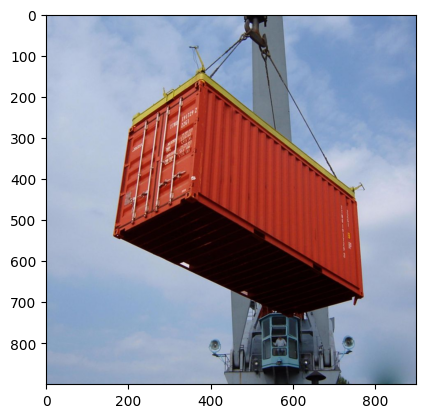

In [5]:
source = cv2.imread("img2.jpeg")

plot_img(source)

Ищем контейнеры


0: 640x640 1 Hook, 1 Shipping container, 1147.7ms
Speed: 20.0ms preprocess, 1147.7ms inference, 1427.5ms postprocess per image at shape (1, 3, 640, 640)


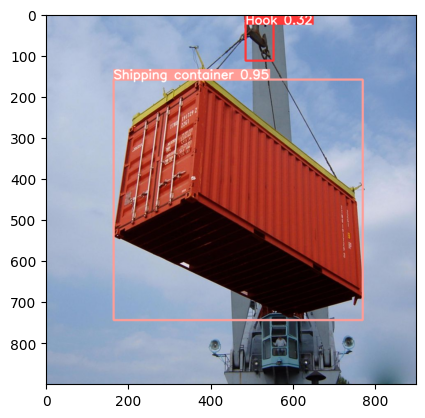

In [6]:
results = model(source, iou=0.5)
# for i in results:

plot_img(results[0].plot())

Смотрим ч у нас в боксе

In [7]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 0.])
conf: tensor([0.9518, 0.3185])
data: tensor([[1.6438e+02, 1.5913e+02, 7.7064e+02, 7.4443e+02, 9.5177e-01, 1.0000e+00],
        [4.8566e+02, 0.0000e+00, 5.5352e+02, 1.1353e+02, 3.1847e-01, 0.0000e+00]])
id: None
is_track: False
orig_shape: (900, 900)
shape: torch.Size([2, 6])
xywh: tensor([[467.5086, 451.7809, 606.2530, 585.2959],
        [519.5904,  56.7655,  67.8521, 113.5310]])
xywhn: tensor([[0.5195, 0.5020, 0.6736, 0.6503],
        [0.5773, 0.0631, 0.0754, 0.1261]])
xyxy: tensor([[164.3822, 159.1329, 770.6351, 744.4288],
        [485.6644,   0.0000, 553.5164, 113.5310]])
xyxyn: tensor([[0.1826, 0.1768, 0.8563, 0.8271],
        [0.5396, 0.0000, 0.6150, 0.1261]])

Обрезаем фотку

In [8]:
top_left = (np.array(results[0].boxes.xyxy[0, :2], dtype=int))
bottom_right = (np.array(results[0].boxes.xyxy[0, 2:],  dtype=int))
cropped_img = source[0:bottom_right[1], top_left[0]:bottom_right[0]]

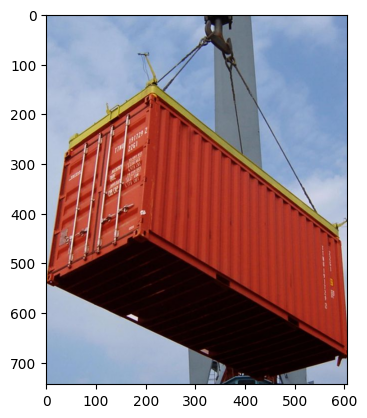

True

In [9]:
plot_img(cropped_img)
name_of_cropped_file = "cropped_img.jpg"
cv2.imwrite("cropped_img.jpg", cropped_img)

Ищем прямые на картинке 

In [10]:
import kornia as K
import kornia.feature as KF
import torch

In [11]:
torch_img1 = K.io.load_image(name_of_cropped_file, K.io.ImageLoadType.RGB32)[None, ...]
cropped_img.shape

(744, 606, 3)

In [12]:
# First, convert the images to gray scale
torch_img1_gray = K.color.rgb_to_grayscale(torch_img1)

In [13]:
sold2 = KF.SOLD2(pretrained=True, config=None)

In [14]:
%%capture
with torch.inference_mode():
    outputs = sold2(torch_img1_gray)

In [15]:
outputs

{'junction_heatmap': tensor([[[6.1867e-04, 1.2766e-04, 7.8530e-05,  ..., 7.2216e-04, 7.2481e-04, 5.3106e-04],
          [7.2525e-05, 8.2871e-06, 2.0139e-06,  ..., 5.7913e-05, 7.0550e-05, 2.9844e-05],
          [5.1792e-05, 3.0417e-06, 7.9869e-07,  ..., 4.9219e-05, 3.3078e-05, 1.4287e-05],
          ...,
          [9.9713e-05, 3.3946e-06, 2.3382e-06,  ..., 9.4916e-05, 1.9147e-04, 5.9712e-05],
          [9.3616e-05, 4.9361e-06, 4.1335e-06,  ..., 8.3283e-05, 9.8730e-05, 5.6365e-05],
          [5.8956e-04, 5.1348e-05, 3.9436e-05,  ..., 1.1274e-03, 1.1008e-03, 5.0694e-04]]]),
 'line_heatmap': tensor([[[1.9964e-03, 1.0735e-03, 5.0999e-04,  ..., 2.1377e-04, 5.7436e-04, 1.3506e-03],
          [1.0329e-03, 5.2295e-04, 2.3158e-04,  ..., 7.1276e-05, 1.8928e-04, 5.3470e-04],
          [6.4564e-04, 3.2714e-04, 9.8334e-05,  ..., 2.1688e-05, 6.0062e-05, 1.8187e-04],
          ...,
          [2.5763e-04, 1.5613e-04, 8.3951e-05,  ..., 9.3126e-05, 1.9874e-04, 3.6122e-04],
          [5.8756e-04, 2.4740e-

In [16]:
line_seg = outputs["line_segments"][0]
desc = outputs["dense_desc"][0]

тут идет отрисовка двух картинок как в примере, переделывать лень

In [17]:
import copy

import matplotlib
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import numpy as np


def plot_images(imgs, titles=None, cmaps="gray", dpi=100, size=6, pad=0.5):
    """Plot a set of images horizontally.
    Args:
        imgs: a list of NumPy or PyTorch images, RGB (H, W, 3) or mono (H, W).
        titles: a list of strings, as titles for each image.
        cmaps: colormaps for monochrome images.
    """
    n = len(imgs)
    if not isinstance(cmaps, (list, tuple)):
        cmaps = [cmaps] * n
    figsize = (size * n, size * 3 / 4) if size is not None else None
    fig, ax = plt.subplots(1, n, figsize=figsize, dpi=dpi)
    if n == 1:
        ax = [ax]
    for i in range(n):
        ax[i].imshow(imgs[i], cmap=plt.get_cmap(cmaps[i]))
        ax[i].get_yaxis().set_ticks([])
        ax[i].get_xaxis().set_ticks([])
        ax[i].set_axis_off()
        for spine in ax[i].spines.values():  # remove frame
            spine.set_visible(False)
        if titles:
            ax[i].set_title(titles[i])
    fig.tight_layout(pad=pad)


def plot_lines(lines, line_colors="orange", point_colors="cyan", ps=4, lw=2, indices=(0, 1)):
    """Plot lines and endpoints for existing images.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        colors: string, or list of list of tuples (one for each keypoints).
        ps: size of the keypoints as float pixels.
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    if not isinstance(line_colors, list):
        line_colors = [line_colors] * len(lines)
    if not isinstance(point_colors, list):
        point_colors = [point_colors] * len(lines)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines and junctions
    for a, l, lc, pc in zip(axes, lines, line_colors, point_colors):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=lc,
                linewidth=lw,
            )
            a.add_line(line)
        pts = l.reshape(-1, 2)
        a.scatter(pts[:, 1], pts[:, 0], c=pc, s=ps, linewidths=0, zorder=2)


def plot_color_line_matches(lines, lw=2, indices=(0, 1)):
    """Plot line matches for existing images with multiple colors.
    Args:
        lines: list of ndarrays of size (N, 2, 2).
        lw: line width as float pixels.
        indices: indices of the images to draw the matches on.
    """
    n_lines = len(lines[0])

    cmap = plt.get_cmap("nipy_spectral", lut=n_lines)
    colors = np.array([mcolors.rgb2hex(cmap(i)) for i in range(cmap.N)])

    np.random.shuffle(colors)

    fig = plt.gcf()
    ax = fig.axes
    assert len(ax) > max(indices)
    axes = [ax[i] for i in indices]
    fig.canvas.draw()

    # Plot the lines
    for a, l in zip(axes, lines):
        for i in range(len(l)):
            line = matplotlib.lines.Line2D(
                (l[i, 1, 1], l[i, 0, 1]),
                (l[i, 1, 0], l[i, 0, 0]),
                zorder=1,
                c=colors[i],
                linewidth=lw,
            )
            a.add_line(line)

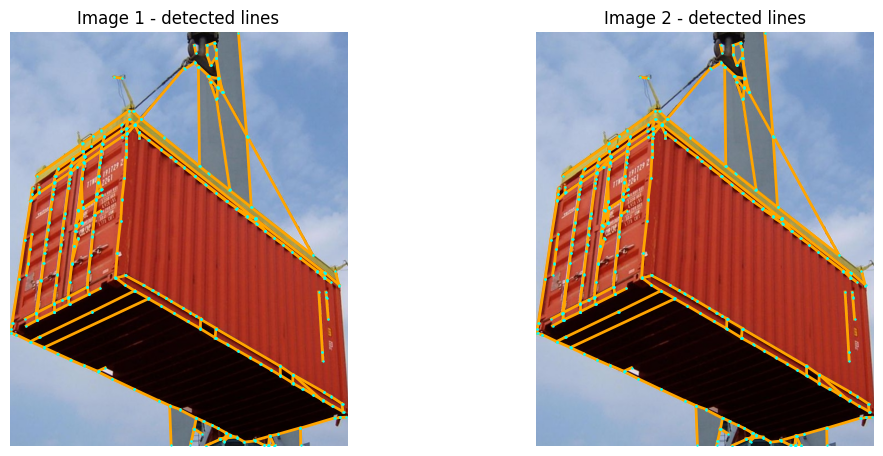

In [18]:
imgs_to_plot = [K.tensor_to_image(torch_img1), K.tensor_to_image(torch_img1)]
lines_to_plot = [line_seg.numpy(), line_seg.numpy()]

plot_images(imgs_to_plot, ["Image 1 - detected lines", "Image 2 - detected lines"])
plot_lines(lines_to_plot, ps=3, lw=2, indices={0, 1})